---
---

# Vorhersage des Schlaganfallrisikos auf Basis von Patientendaten: Evaluation klassischer Klassifikationsverfahren
---
---

# Imports and Settings
---

In [1552]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    StratifiedKFold,
    GridSearchCV,
    cross_validate
)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier


# Task 1 -- Context

<div class="alert alert-block alert-warning">
This task sets the stage for the subsequent tasks as it determines the context for the experiments. For
that purpose:

1. You present a real scenario or a (realistic) fictitious situation, in which you are the data scientist. You propose to solve a classification or regression problem and want to convince a customer to green-light your project.
2. You explain the value (monetary or otherwise) of solving the problem and what the customer could do with the model you train (if successful).
3. Name two quality criteria that you will use in the following tasks to evaluate your models. Explain your choice!
</div>

#### 1. Szenario

Ich schlüpfe in die Rolle eines Data Scientists, der für ein medizinisches Versorgungszentrum arbeitet. Ziel ist es, ein prädiktives Modell zu entwickeln, das anhand von Patientendaten (z. B. Alter, Geschlecht, Vorerkrankungen, Lebensstilfaktoren) das Risiko für einen Schlaganfall vorhersagt. Dieses Projekt basiert auf einem realistisch simulierten Szenario, bei dem historische Daten aus Vorsorgeuntersuchungen analysiert werden, um Frühwarnsysteme zu entwickeln.

#### 2. Wert des Projekts

Ein erfolgreiches Modell könnte medizinischen Einrichtungen helfen, gefährdete Personen frühzeitig zu identifizieren und gezielte Präventionsmaßnahmen einzuleiten. Dadurch könnten nicht nur schwere gesundheitliche Folgen für Betroffene reduziert, sondern auch langfristig Kosten im Gesundheitssystem gesenkt werden. Das Modell wäre z. B. als Entscheidungsunterstützung im Rahmen von Vorsorgeuntersuchungen einsetzbar, um bei auffälligen Risikoprofilen weitere diagnostische Schritte einzuleiten.

#### 3. Qualitätskriterien

Zur Bewertung der Modelle werden folgende Metriken verwendet:

- **Recall (Sensitivität):** Da es sich bei Schlaganfällen um kritische, aber seltene Ereignisse handelt, ist es besonders wichtig, möglichst viele tatsächliche Schlaganfallfälle zu erkennen. Ein hoher Recall stellt sicher, dass gefährdete Personen möglichst selten übersehen werden.
  
- **F1-Score:** Da ein reines Maximieren von Recall zu vielen falsch-positiven Warnungen führen kann, wird zusätzlich der F1-Score berücksichtigt. Er bildet den Kompromiss zwischen Precision und Recall und ist besonders geeignet bei unausgeglichenen Klassenverteilungen, wie sie im vorliegenden Datensatz gegeben sind.

Diese beiden Metriken ermöglichen eine ausgewogene Bewertung der Modellgüte im medizinischen Kontext, bei dem sowohl die Erkennungsrate als auch die Verlässlichkeit der Vorhersage wichtig sind.

# Task 2 -- The Data

<div class="alert alert-block alert-warning">
Load and present a dataset (respect the conditions in Section 2). This will be the raw data, that you’ll
exploit in the subsequent tasks.
</div>

In [1553]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


<div class="alert alert-block alert-warning">
Explain the dataset itself (e.g., what do the features and target represent?).
</div>

#### Beschreibung des Datensatzes

Für das Projekt wird ein medizinischer Datensatz verwendet, der demografische und gesundheitsbezogene Informationen von Patienten enthält. Ziel ist es, anhand dieser Merkmale das Risiko für einen Schlaganfall vorherzusagen.

Der Datensatz umfasst folgende Spalten:

| Column Name        | Description                                                                 |
|---------------------|------------------------------------------------------------------------------|
| `id`               | Eindeutiger Identifikator jeder Person                                       |
| `gender`           | Geschlecht: "Male", "Female" oder "Other"                                    |
| `age`              | Alter der Person (numerischer Wert)                                          |
| `hypertension`     | 0 = keine Hypertonie, 1 = hat Hypertonie                                     |
| `heart_disease`    | 0 = keine Herzerkrankung, 1 = hat Herzerkrankung                             |
| `ever_married`     | "No" oder "Yes" – ob die Person jemals verheiratet war                       |
| `work_type`        | Art der beruflichen Tätigkeit: "children", "Govt_job", "Never_worked", "Private", "Self-employed" |
| `Residence_type`   | Wohnumfeld: "Urban" oder "Rural"                                             |
| `avg_glucose_level`| Durchschnittlicher Blutzuckerspiegel (numerisch)                            |
| `bmi`              | Body-Mass-Index (numerisch)                                                  |
| `smoking_status`   | Rauchstatus: "formerly smoked", "never smoked", "smokes" oder "Unknown"      |
| `stroke`           | Zielvariable: 1 = hatte einen Schlaganfall, 0 = hatte keinen Schlaganfall    |


Der Datensatz ist hier zu finden: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


<div class="alert alert-block alert-warning">
Explain how the dataset is suitable for the project from Task 1.
</div>

#### Relevanz für das Projekt

Der Datensatz eignet sich für das in **Task 1** definierte Projektziel, da er sowohl demografische als auch medizinische Risikofaktoren enthält, die mit der Wahrscheinlichkeit eines Schlaganfalls in Verbindung stehen können. Dazu zählen unter anderem bekannte Einflussgrößen wie Alter, Bluthochdruck, Herzerkrankungen, Übergewicht (BMI), Blutzuckerspiegel und Rauchverhalten.

Darüber hinaus enthält der Datensatz sowohl numerische als auch kategoriale Merkmale, was ihn zu einer praxisnahen Grundlage für die Entwicklung und den Vergleich von Klassifikationsmodellen macht. Die Zielvariable (`stroke`) ist klar binär definiert und somit für ein Klassifikationsproblem gut geeignet.

# Task 3 -- IDA

<div class="alert alert-block alert-warning">
Conduct an initial data analysis.

* Present some relevant statistical properties that inform the reader about the dataset or that are relevant for your project.
</div>

In [1554]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [1555]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [1556]:
data['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [1557]:
data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

# Task 4 -- EDA and Preprocessing

<div class="alert alert-block alert-warning">
Bring the dataset into the form that you need for the experiments.

* Explore the data and conduct necessary transformations.
* Visualize or summarize aspects of the dataset (statistics, ranges, distributions, . . . ).
* If necessary, use different means of preprocessing until the dataset is suitable.
* If you change data, do not forget to present and summarize relevant properties and distributions
of the result.
</div>

Die fehlenden BMI-Werte (3,9 % aller Einträge) werden entfernt. Aufgrund des vergleichsweise geringen Anteils ist der Einfluss auf die Analyse vernachlässigbar. Eine Imputation wäre zwar möglich, wird hier jedoch nicht als notwendig erachtet.

In [1558]:
data = data.dropna()

Der Wert ‚Unknown‘ beim Raucherstatus wurde als eigene Kategorie beibehalten, da dieser Anteil fast ein Drittel des ursprünglichen Datensatzes ausmacht. Es ist denkbar, dass Personen, die keine Angabe gemacht haben, eher zu den Nichtrauchern zählen – dennoch lässt sich dies nicht mit Sicherheit belegen. Durch das Beibehalten dieser Gruppe als eigenständige Kategorie kann das Modell möglicherweise Muster erkennen, die mit dieser fehlenden Angabe korrelieren. Gleichzeitig wird so vermieden, dass ein erheblicher Teil der Daten verloren geht.

In [1559]:
data = data.drop(columns=['id'])

Die Spalte ID ist in diesem Fall irrelevant, weshalb sie eleminiert wird.

In [1560]:
# Verteilung der Zielvariablen
no_stroke_counts, stroke_counts = data['stroke'].value_counts()
no_stroke_percent, stroke_percent = data['stroke'].value_counts(normalize=True) * 100
print(f"Keinen Schlaganfall: {no_stroke_counts}")
print(f"Schlaganfall: {stroke_counts}")

print(f"Keinen Schlaganfall: {no_stroke_percent:.2f}%")
print(f"Schlaganfall: {stroke_percent:.2f}%")

Keinen Schlaganfall: 4700
Schlaganfall: 209
Keinen Schlaganfall: 95.74%
Schlaganfall: 4.26%


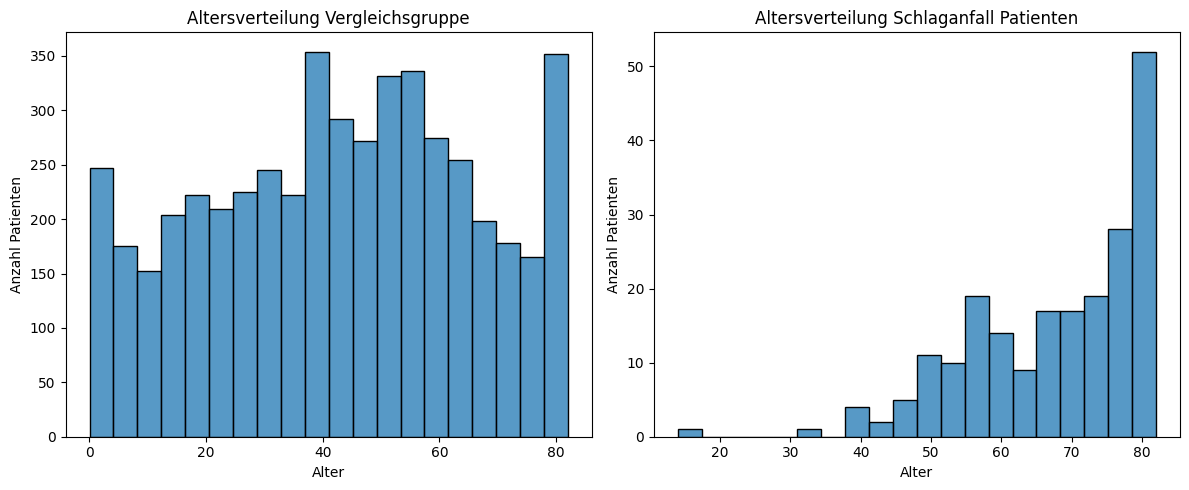

In [1561]:
# Nur Schlaganfall-Patienten
stroke_patients = data[data['stroke'] == 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.histplot(data['age'], bins=20, ax=axes[0])
axes[0].set_title('Altersverteilung Vergleichsgruppe')
axes[0].set_xlabel('Alter')
axes[0].set_ylabel('Anzahl Patienten')

# Plot 2
sns.histplot(stroke_patients['age'], bins=20, ax=axes[1])
axes[1].set_title('Altersverteilung Schlaganfall Patienten')
axes[1].set_xlabel('Alter')
axes[1].set_ylabel('Anzahl Patienten')

plt.tight_layout()
plt.show()

Die Verteilung zeigt, dass Schlaganfälle vor allem ältere Personen betreffen. Ab etwa 60 Jahren steigt die Fallzahl deutlich an, mit einem Höhepunkt bei über 75-Jährigen. Alter ist damit ein zentraler Prädiktor für das Schlaganfallrisiko.

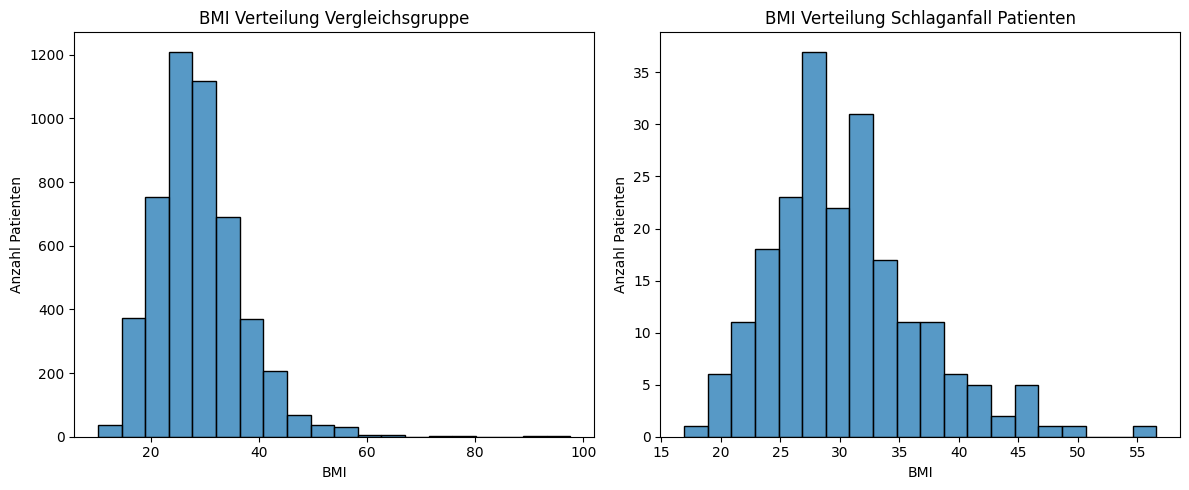

In [1562]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.histplot(data['bmi'], bins=20, ax=axes[0])
axes[0].set_title('BMI Verteilung Vergleichsgruppe')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Anzahl Patienten')

# Plot 2
sns.histplot(stroke_patients['bmi'], bins=20, ax=axes[1])
axes[1].set_title('BMI Verteilung Schlaganfall Patienten')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Anzahl Patienten')

plt.tight_layout()
plt.show()

Die Analyse der BMI-Verteilung zeigt, dass Schlaganfall-Patienten im Vergleich zur Gesamtpopulation tendenziell einen etwas höheren BMI aufweisen.
Der Unterschied ist jedoch nicht sehr ausgeprägt, was darauf hindeutet, dass der BMI kein alleiniger Risikofaktor, sondern möglicherweise nur in Kombination mit anderen Merkmalen relevant ist.

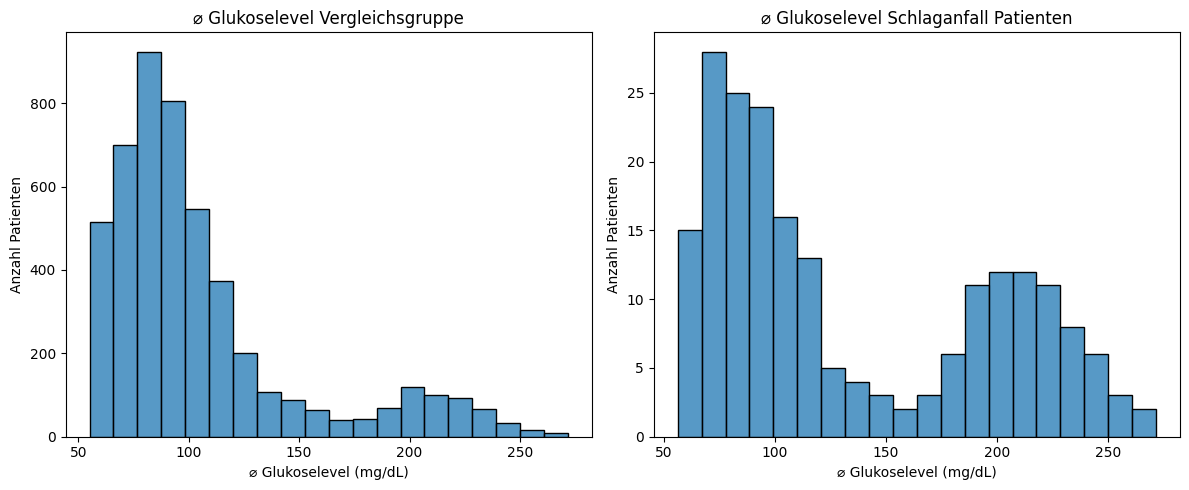

In [1563]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1
sns.histplot(data['avg_glucose_level'], bins=20, ax=axes[0])
axes[0].set_title('⌀ Glukoselevel Vergleichsgruppe')
axes[0].set_xlabel('⌀ Glukoselevel (mg/dL)')
axes[0].set_ylabel('Anzahl Patienten')

# Plot 2
sns.histplot(stroke_patients['avg_glucose_level'], bins=20, ax=axes[1])
axes[1].set_title('⌀ Glukoselevel Schlaganfall Patienten')
axes[1].set_xlabel('⌀ Glukoselevel (mg/dL)')
axes[1].set_ylabel('Anzahl Patienten')

plt.tight_layout()
plt.show()

Die Analyse der durchschnittlichen Glukosewerte zeigt, dass bei Schlaganfall-Patienten eine auffällige Häufung im Bereich über 200 mg/dL zu beobachten ist – ein Bereich, der typischerweise mit Diabetes oder stark gestörter Glukoseverwertung in Verbindung gebracht wird.
Während die Gesamtverteilung der Glukoselevel klar rechtsschief ist, fällt bei der Gruppe der Betroffenen eine zweite Spitze bei sehr hohen Werten auf.
Dies unterstützt die Hypothese, dass eine gestörte Glukoseverarbeitung ein signifikanter Risikofaktor für Schlaganfälle sein kann.

In [1564]:
# Ausgewählte kategoriale Merkmale, die analysiert werden sollen
features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Dictionary zur Speicherung der Ergebnis-Tabellen
summary_tables = {}

# Für jedes Merkmal eine Auswertung erstellen
for feature in features:
    # Schlaganfallanteil pro Kategorie (Spalte = 1 = Schlaganfall) in Prozent
    stroke_percent = pd.crosstab(data[feature], data['stroke'], normalize='index') * 100
    # Absolute Häufigkeit je Kategorie
    value_counts = data[feature].value_counts()
    # Prozentualer Anteil je Kategorie
    value_percent = data[feature].value_counts(normalize=True) * 100

    # Zusammenfassung als DataFrame
    summary = pd.DataFrame({
        'Anzahl Personen': value_counts,
        'Anteil (%)': value_percent,
        'Schlaganfall Patient (%)': stroke_percent[1]
    })
    
    # Tabelle in Dictionary speichern
    summary_tables[feature] = summary

### Merkmalsbasierte Analyse der Zielvariable

Um potenzielle Zusammenhänge zwischen den verfügbaren Patientenmerkmalen und dem Auftreten eines Schlaganfalls zu untersuchen, wurde die Zielvariable `stroke` in Abhängigkeit verschiedener kategorialer Merkmale ausgewertet. Für jedes Merkmal wird die Verteilung innerhalb der Gesamtdaten betrachtet sowie der relative Anteil an Schlaganfallpatienten pro Ausprägung berechnet.

### Geschlecht (`gender`)

Die Stichprobe setzt sich zu ca. 59 % aus Frauen und ca. 41 % aus Männern zusammen. Der Anteil an Schlaganfällen ist in beiden Gruppen nahezu gleich: 4,14 % bei Frauen und 4,43 % bei Männern. Diese geringe Differenz lässt auf keinen klaren Zusammenhang zwischen Geschlecht und Schlaganfallhäufigkeit schließen. Die Kategorie „Other“ tritt nur einmal auf und weist keinen Schlaganfallfall auf; sie ist daher für weitere Auswertungen nicht relevant.

In [1565]:
summary_tables['gender']

,Anzahl Personen,Anteil (%),Schlaganfall Patient (%)
gender,,,
Female,2897,59.014056,4.142216
Male,2011,40.965573,4.425659
Other,1,0.020371,0.000000


In [1566]:
data = data[data['gender'].isin(['Male', 'Female'])]  # ich schließe 'Other' aus, weil es nur eine einzige Person ist

### Bluthochdruck (`hypertension`)

Etwa 9,2 % der Personen im Datensatz sind von Bluthochdruck betroffen. In dieser Gruppe liegt der Anteil an Schlaganfallfällen bei 13,3 % – deutlich höher als bei Personen ohne Bluthochdruck (3,3 %). Dieses Ergebnis deutet darauf hin, dass Bluthochdruck ein relevanter Risikofaktor für Schlaganfälle ist.

In [1567]:
summary_tables['hypertension']

,Anzahl Personen,Anteil (%),Schlaganfall Patient (%)
hypertension,,,
0,4458,90.812793,3.342306
1,451,9.187207,13.303769


### Herzkrankheiten (`heartdisease`)

Lediglich rund 5 % der Personen im Datensatz weisen eine diagnostizierte Herzerkrankung auf. In dieser Gruppe liegt der Schlaganfallanteil jedoch bei 16,5 %, während er bei den übrigen Personen nur 3,6 % beträgt. Dies deutet auf einen starken Zusammenhang zwischen Herzerkrankungen und Schlaganfallrisiko hin.

In [1568]:
summary_tables['heart_disease']

,Anzahl Personen,Anteil (%),Schlaganfall Patient (%)
heart_disease,,,
0,4666,95.049908,3.621946
1,243,4.950092,16.460905


### Familienstand (`ever_married`)

Etwa zwei Drittel der Personen (65 %) geben an, verheiratet gewesen zu sein oder es aktuell zu sein. Innerhalb dieser Gruppe liegt der Anteil an Schlaganfällen bei 5,8 %, während er bei den unverheirateten Personen nur 1,3 % beträgt. Dies könnte darauf hinweisen, dass verheiratete Personen tendenziell älter sind – Alter könnte hier also ein konfundierender Faktor sein, der das Ergebnis beeinflusst.

In [1569]:
summary_tables['ever_married']

,Anzahl Personen,Anteil (%),Schlaganfall Patient (%)
ever_married,,,
No,1705,34.732125,1.348974
Yes,3204,65.267875,5.805243


#### Zusammenhang zwischen Familienstand und Alter

Da ein deutlicher Unterschied im Schlaganfallanteil zwischen verheirateten (5,8 %) und unverheirateten Personen (1,3 %) festgestellt wurde, wurde überprüft, ob das Alter als möglicher konfundierender Faktor diese Beobachtung beeinflussen könnte. 

Ein Boxplot der Altersverteilung nach Familienstand zeigt, dass verheiratete Personen im Durchschnitt deutlich älter sind als unverheiratete. Während der Altersbereich der unverheirateten Gruppe vorwiegend unter 40 Jahren liegt, ist der Altersbereich der verheirateten Gruppe deutlich breiter und verschoben in höhere Altersklassen.

Diese Beobachtung legt nahe, dass das erhöhte Schlaganfallrisiko bei verheirateten Personen nicht primär auf den Familienstand selbst zurückzuführen ist, sondern vielmehr auf das höhere Alter innerhalb dieser Gruppe. Das Merkmal `ever_married` ist somit potenziell stark mit dem Alter korreliert und sollte in nachfolgenden Analysen nur unter Berücksichtigung dieser Wechselwirkung interpretiert werden.

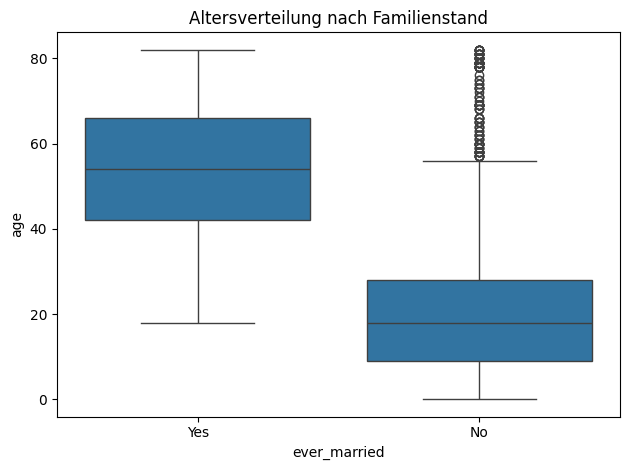

In [1570]:
# Altersverteilung je ever_married
sns.boxplot(data=data, x='ever_married', y='age')
plt.title("Altersverteilung nach Familienstand")
plt.tight_layout()
plt.show()

### Berufstyp (`work_type`)
Die größte Gruppe im Datensatz sind privat angestellte Personen (57 %), gefolgt von Selbstständigen (ca. 16 %) und Personen im Staatsdienst (ca. 13 %). Auffällig ist, dass der Anteil an Schlaganfallpatienten unter Selbstständigen mit 6,8 % höher ist als in den übrigen Gruppen. Personen in der Kategorie „children“ (nicht erwerbstätig aufgrund des Alters) sowie „never_worked“ weisen kaum oder gar keine Schlaganfälle auf. Letzteres dürfte mit dem jungen Alter dieser Personen zusammenhängen, was auch die extrem niedrige Schlaganfallrate (0 %) in dieser Gruppe erklären würde.

In [1571]:
summary_tables['work_type']

,Anzahl Personen,Anteil (%),Schlaganfall Patient (%)
work_type,,,
Govt_job,630,12.833571,4.444444
Never_worked,22,0.448156,0.000000
Private,2811,57.262172,4.517965
Self-employed,775,15.787329,6.838710
children,671,13.668772,0.149031


#### Geschlechtsverteilung innerhalb der Berufsgruppen

Eine genauere Analyse zeigt, dass die Berufsgruppen relativ gleichmäßig nach Geschlecht verteilt sind. Beispielsweise sind rund 61 % der Selbstständigen weiblich, ebenso wie knapp 61 % der Personen im Staatsdienst. In der Gruppe der nicht berufstätigen Kinder ist das Verhältnis nahezu ausgeglichen.

In [1572]:
# Verteilung Geschlecht vs. Berufsgruppe
pd.crosstab(data['work_type'], data['gender'], normalize='index') * 100

gender,Female,Male
work_type,,
Govt_job,60.952381,39.047619
Never_worked,50.000000,50.000000
Private,60.676157,39.323843
Self-employed,61.548387,38.451613
children,47.690015,52.309985



#### Schlaganfallanteil nach Beruf und Geschlecht

Ein Blick auf die Schlaganfallraten getrennt nach Geschlecht innerhalb der Berufsgruppen zeigt leichte Unterschiede: Bei Selbstständigen liegt der Schlaganfallanteil bei Männern bei 6,7 % und bei Frauen bei 6,9 %. In der Gruppe der Staatsbediensteten zeigt sich ein geringfügig höheres Risiko bei Frauen (4,9 %) im Vergleich zu Männern (3,7 %). Diese Unterschiede könnten durch andere, nicht beobachtete Faktoren bedingt sein (z. B. Alter oder Gesundheitsstatus), zeigen aber, dass auch innerhalb einzelner Berufskategorien relevante Unterschiede existieren könnten

In [1573]:
# Durchschnittlicher Schlaganfallanteil (%) pro Kombination aus Berufsgruppe und Geschlecht
data.groupby(['work_type', 'gender'])['stroke'].mean() * 100

work_type      gender
Govt_job       Female    4.947917
               Male      3.658537
Never_worked   Female    0.000000
               Male      0.000000
Private        Female    3.929619
               Male      5.429864
Self-employed  Female    6.918239
               Male      6.711409
children       Female    0.312500
               Male      0.000000
Name: stroke, dtype: float64

### Wohnort (`residence_type`)

Die Verteilung zwischen ländlichem (49 %) und städtischem Raum (51 %) ist nahezu ausgeglichen. Der Unterschied im Schlaganfallanteil ist geringfügig höher bei städtisch lebenden Personen (4,38 % vs. 4,13 %). Diese Differenz ist minimal und deutet nicht auf einen klaren Zusammenhang zwischen Wohnort und Schlaganfallrisiko hin.

In [1574]:
summary_tables['Residence_type']

,Anzahl Personen,Anteil (%),Schlaganfall Patient (%)
Residence_type,,,
Rural,2419,49.276838,4.13394
Urban,2490,50.723162,4.37751


### Raucherstatus (`smoking_status`)

Etwa 15 % der Personen im Datensatz sind aktuelle Raucher:innen, 17 % haben früher geraucht, 38 % haben nie geraucht und bei rund 30 % ist der Rauchstatus unbekannt. Der höchste Anteil an Schlaganfallfällen findet sich unter den ehemaligen Rauchern (6,8 %). Eine mögliche Erklärung hierfür könnte eine bereits vorhandene gesundheitliche Vorbelastung sein, die sowohl zum Rauchstopp als auch zum erhöhten Schlaganfallrisiko geführt haben könnte. 

Aktuelle Raucher weisen mit 5,3 % ein leicht erhöhtes Risiko im Vergleich zu Nichtrauchern (4,5 %) auf. Die niedrigste Rate findet sich in der Gruppe mit unbekanntem Rauchverhalten (2,0 %). Dies könnte darauf hindeuten, dass sich in dieser Gruppe überdurchschnittlich viele gesunde bzw. nichtrauchende Personen befinden. Dies unterstützt die Entscheidung, diese Gruppe nicht eleminiert zu haben.

In [1575]:
summary_tables['smoking_status']

,Anzahl Personen,Anteil (%),Schlaganfall Patient (%)
smoking_status,,,
Unknown,1483,30.209819,1.955496
formerly smoked,837,17.050316,6.810036
never smoked,1852,37.726625,4.535637
smokes,737,15.013241,5.291723


#### Zusammenhang zwischen Rauchverhalten, Bluthochdruck und Herzerkrankungen

Zur weiteren Einordnung der Ergebnisse wurde untersucht, ob das Rauchverhalten mit anderen gesundheitlichen Risikofaktoren wie Bluthochdruck (`hypertension`) oder Herzerkrankungen (`heart_disease`) in Verbindung steht. Dabei zeigt sich:

- In der Gruppe der ehemaligen Raucher leiden überdurchschnittlich viele Personen unter Bluthochdruck (ca. 9,7 %) und Herzerkrankungen (8,4 %) im Vergleich zu den anderen Gruppen.
- Aktuelle Raucher haben ebenfalls erhöhte Anteile an Bluthochdruck (ca. 7,5 %) und Herzerkrankungen (7,5 %), liegen damit aber unter den Ex-Rauchern.
- Personen mit unbekanntem Rauchstatus zeigen die niedrigsten Raten: Nur ca. 2,5 % haben Herzerkrankungen und ca. 2,5 % Bluthochdruck.

Diese Beobachtungen unterstützen die Hypothese, dass bei ehemaligen Rauchern möglicherweise bereits gesundheitliche Vorbelastungen vorlagen, die sowohl den Rauchstopp als auch das höhere Schlaganfallrisiko erklären könnten. Gleichzeitig deutet der geringe Anteil an Begleiterkrankungen in der „Unknown“-Gruppe darauf hin, dass es sich hierbei häufig um gesunde bzw. nichtrauchende Personen handeln könnte.

Die Entscheidung, den unbekannten Rauchstatus nicht aus dem Datensatz zu entfernen, wird dadurch weiter gestützt.

In [1576]:
# Verteilung von Bluthochdruck (Hypertension) innerhalb der Rauchstatus-Gruppen
pd.crosstab(data['smoking_status'], data['hypertension'], normalize='index') * 100

hypertension,0,1
smoking_status,,
Unknown,97.100472,2.899528
formerly smoked,86.842105,13.157895
never smoked,88.336933,11.663067
smokes,88.873813,11.126187


In [1577]:
# Verteilung von Herzkrankheiten innerhalb der Rauchstatus-Gruppen
pd.crosstab(data['smoking_status'], data['heart_disease'], normalize='index') * 100

heart_disease,0,1
smoking_status,,
Unknown,97.505057,2.494943
formerly smoked,91.626794,8.373206
never smoked,95.626350,4.373650
smokes,92.537313,7.462687


# Task 5 -- First Impressions

<div class="alert alert-block alert-warning">
Determine an appropriate simple baseline 𝐵 (no trained model) for your task.
</div>

### Definition der Baseline `B`

Als einfache Baseline `B` wird ein Modell definiert, das bei jeder Vorhersage stets die Mehrheitsklasse im Datensatz auswählt. Da es sich bei der vorliegenden Problemstellung um ein Klassifikationsproblem mit einer stark unausgeglichenen Zielvariable (`stroke`) handelt – nur etwa 5 % der Personen im Datensatz haben einen Schlaganfall erlitten – ist die Mehrheitsklasse eindeutig `stroke = 0` (kein Schlaganfall).

Diese Baseline repräsentiert ein „naives“ Verfahren ohne jegliches Lernen aus den Daten. Sie bietet einen sinnvollen Referenzwert zur Beurteilung der Modellgüte, da ein Klassifikationsmodell nur dann als leistungsfähig betrachtet werden kann, wenn es **deutlich besser** abschneidet als diese triviale Lösung.

Die Berechnung und Bewertung der Baseline erfolgt später im Rahmen des train/test-Splits.

<div class="alert alert-block alert-warning">
Select two ML algorithms 𝐴1 and 𝐴2 from the lectures (or their regression counterparts) and
use their implementations in scikit-learn.
</div>

Ich wähle den Decision Tree Classifier als Algorithmus A₁, da er robuste und interpretierbare Vorhersagemodelle bietet. Entscheidungsbäume eignen sich besonders gut für gemischte Datentypen – sowohl numerische als auch kategoriale Features können problemlos verarbeitet werden. Ein weiterer Vorteil ist, dass Decision Trees keine Standardisierung oder Skalierung der Features erfordern. Auch mit unausgeglichenen Datensätzen kann ein Entscheidungsbaum gut umgehen. Zudem bietet dieses Modell die Möglichkeit, Entscheidungswege nachvollziehbar zu visualisieren, was für die Analyse medizinischer Daten (z. B. zur Schlaganfall-Vorhersage) besonders nützlich sein kann.

Als zweiten Algorithmus A₂ nutze ich Naive Bayes, da mein Datensatz viele kategoriale Merkmale enthält (z. B. `work_type`, `smoking_status`, `gender`, …). Mit dem CategoricalNB-Modell können diese Merkmale direkt als diskrete Zahlenwerte verarbeitet werden – ohne auf One-Hot-Encoding angewiesen zu sein. Naive Bayes ist sehr effizient, arbeitet schnell und liefert oft gute Ergebnisse, auch wenn die Unabhängigkeitsannahme nicht perfekt erfüllt ist. Durch den Vergleich mit einem komplexeren Modell wie dem Decision Tree kann untersucht werden, ob ein einfaches Modell bereits gute Vorhersageleistung erzielt.

<div class="alert alert-block alert-warning">
Briefly discuss relevant dataset transformations that have to be used with each of the algorithms.
Apply them in all tasks where necessary and appropriate!
</div>

### Datentransformationen je Algorithmus

#### Baseline (`DummyClassifier`)
Für den DummyClassifier sind keine Datenvorverarbeitungen notwendig, da dieses Modell die Zielvariable ignoriert und lediglich die häufigste Klasse vorhersagt. Der Klassifikator dient rein als Vergleichsmaßstab.

#### Decision Tree (`DecisionTreeClassifier`)
Entscheidungsbäume können sowohl mit numerischen als auch mit kategorialen Merkmalen arbeiten. Wichtig ist lediglich, dass kategoriale Merkmale in **diskrete numerische Werte** umgewandelt werden (z. B. 0, 1, 2), was z. B. durch Label-Encoding geschieht. Es ist **kein One-Hot-Encoding** und **keine Skalierung** notwendig.

Folgende Merkmale wurden als kategorial eingestuft und entsprechend codiert:  
`gender`, `work_type`, `Residence_type`, `smoking_status`, `ever_married`

#### Naive Bayes (`CategoricalNB`)
Für das Modell CategoricalNB müssen **alle Merkmale als diskrete, nicht-negative Ganzzahlen** vorliegen. Daher wurden auch kontinuierliche Merkmale wie `age`, `bmi` und `avg_glucose_level` in **Binning-Kategorien** überführt (z. B. jung/mittel/alt oder normal/übergewichtig).

Sowohl kontinuierliche als auch kategoriale Merkmale wurden in diesem Fall in **ganzzahlige Klassenwerte** umgewandelt.

#### Vorbereitete Datensätze
Zur Berücksichtigung der unterschiedlichen Anforderungen wurden zwei separate Datensätze erstellt:

- `data_tree`: Für den Decision Tree (kategoriale Merkmale als Zahlen, kontinuierliche Merkmale bleiben unverändert)
- `data_nb`: Für Naive Bayes (alle Merkmale wurden in diskrete Werte überführt)


In [1578]:
# Kategorische Merkmale für Decision Tree in ganze Zahlen umwandeln
categorical_cols = ['gender', 'work_type', 'smoking_status', 'Residence_type', 'ever_married']
data_tree = data.copy()
enc = OrdinalEncoder()
data_tree[categorical_cols] = enc.fit_transform(data_tree[categorical_cols])
data_tree

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,67.0,0,1,1.0,2.0,1.0,228.69,36.6,1.0,1
2,1.0,80.0,0,1,1.0,2.0,0.0,105.92,32.5,2.0,1
3,0.0,49.0,0,0,1.0,2.0,1.0,171.23,34.4,3.0,1
4,0.0,79.0,1,0,1.0,3.0,0.0,174.12,24.0,2.0,1
5,1.0,81.0,0,0,1.0,2.0,1.0,186.21,29.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,13.0,0,0,0.0,4.0,0.0,103.08,18.6,0.0,0
5106,0.0,81.0,0,0,1.0,3.0,1.0,125.20,40.0,2.0,0
5107,0.0,35.0,0,0,1.0,3.0,0.0,82.99,30.6,2.0,0
5108,1.0,51.0,0,0,1.0,2.0,0.0,166.29,25.6,1.0,0


In [1579]:
data_nb = data.copy()

# Alter in drei Altersgruppen einteilen
bins = [0, 27, 54, 82]
labels = [0, 1, 2]  # Je jünger, desto kleiner der Wert
data_nb['age'] = pd.cut(data_nb['age'], bins=bins, labels=labels)

In [1580]:
# BMI kategorisieren (z. B. normal, übergewichtig etc.)
bins = [0, 18.5, 25, 30, 40, 100]
labels = [0, 1, 2, 3, 4]  # Underweight, Normal, Overweight, Obese I, Obese II
data_nb['bmi'] = pd.cut(data_nb['bmi'], bins=bins, labels=labels)

In [1581]:
# Durchschnittlichen Blutzuckerspiegel kategorisieren
bins = [0, 99, 125, 300]
labels = [0, 1, 2]  # 0 = normal, 1 = erhöhter Wert, 2 = sehr hoch
data_nb['avg_glucose_level'] = pd.cut(data_nb['avg_glucose_level'], bins=bins, labels=labels)

In [1582]:
# Kategorische Merkmale für Naive Bayes in ganze Zahlen umwandeln
categorical_cols = ['gender', 'work_type', 'smoking_status', 'Residence_type', 'ever_married']
enc = OrdinalEncoder()
data_nb[categorical_cols] = enc.fit_transform(data_nb[categorical_cols])
data_nb

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,2,0,1,1.0,2.0,1.0,2,3,1.0,1
2,1.0,2,0,1,1.0,2.0,0.0,1,3,2.0,1
3,0.0,1,0,0,1.0,2.0,1.0,2,3,3.0,1
4,0.0,2,1,0,1.0,3.0,0.0,2,1,2.0,1
5,1.0,2,0,0,1.0,2.0,1.0,2,2,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0,0,0,0.0,4.0,0.0,1,1,0.0,0
5106,0.0,2,0,0,1.0,3.0,1.0,2,3,2.0,0
5107,0.0,1,0,0,1.0,3.0,0.0,0,3,2.0,0
5108,1.0,1,0,0,1.0,2.0,0.0,2,2,1.0,0


<div class="alert alert-block alert-warning">
In a simple train test split, learn and evaluate the baseline 𝐵 and both algorithms, 𝐴1 and 𝐴2,
in their respective default parametrization. Use the quality measures from Task 1. Present the
results in a table and discuss them.
</div>

### Baseline B

In [1583]:
# Features und Zielvariable definieren
X_baseline = data.drop(columns='stroke') # Alle Spalten außer der Zielvariable 'stroke'
y_baseline = data['stroke'] # Zielvariable: 'stroke'

# Datensatz aufteilen in Trainings- und Testdaten (60/40 Split)
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.4, random_state=42, stratify=y_baseline
)

In [1584]:
# Dummy-Klassifikator erstellen (immer häufigste Klasse vorhersagen)
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train_baseline, y_train_baseline)

# Vorhersage auf Testdaten durchführen
y_pred_baseline = baseline.predict(X_test_baseline)

In [1585]:
# Berechnung von Accuracy, Recall und F1-Score
acc_baseline = accuracy_score(y_test_baseline, y_pred_baseline) # Accuracy
rec_baseline = recall_score(y_test_baseline, y_pred_baseline) # Recall
f1_baseline = f1_score(y_test_baseline, y_pred_baseline) # F1-Score

In [1586]:
# Ergebnisse ausgeben
print("Accuracy:", round(acc_baseline, 4))
print("Recall:", round(rec_baseline, 4))
print("F1-Score:", round(f1_baseline, 4))

Accuracy: 0.9572
Recall: 0.0
F1-Score: 0.0


### Decision Tree

In [1587]:
# Features und Zielvariable definieren äquivalent zur Baseline
X_tree = data_tree.drop(columns='stroke')
y_tree = data_tree['stroke']

In [1588]:
# Datensatz aufteilen in Trainings- und Testdaten (60/40 Split)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.4, shuffle=True, stratify=y_tree, random_state=42
)

In [1589]:
# Ausgabe der Datenformate (zur Kontrolle)
print(X_train_tree.shape, y_train_tree.shape, X_test_tree.shape, y_test_tree.shape)

(2944, 10) (2944,) (1964, 10) (1964,)


In [1590]:
# Liste zur Speicherung der F1-Scores für verschiedene Baumtiefen
depths = range(1, 21)
f1_scores = []

# Für jede max_depth von 1 bis 20 einen Decision Tree trainieren und F1-Score berechnen
for d in depths:
    clf = tree.DecisionTreeClassifier(
        criterion='gini',
        max_depth=d,
        class_weight='balanced',
        random_state=42
    )
    clf.fit(X_train_tree, y_train_tree) # Modell auf Trainingsdaten trainieren
    y_pred = clf.predict(X_test_tree) # Vorhersage auf Testdaten
    f1 = f1_score(y_test_tree, y_pred) # F1-Score berechnen
    f1_scores.append(f1)

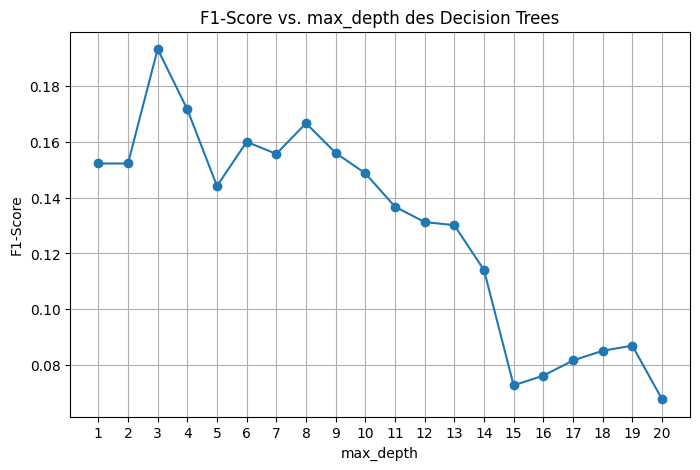

In [1591]:
# F1-Score in Abhängigkeit von max_depth visualisieren
plt.figure(figsize=(8, 5))
plt.plot(depths, f1_scores, marker='o')
plt.title("F1-Score vs. max_depth des Decision Trees")
plt.xlabel("max_depth")
plt.ylabel("F1-Score")
plt.grid(True)
plt.xticks(depths)
plt.show()

In [1592]:
# Entscheidung für einen konkreten Baum mit max_depth = 3
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42, class_weight='balanced')
clf.fit(X_train_tree, y_train_tree)

DecisionTreeClassifier(class_weight='balanced', max_depth=3, random_state=42)

In [1593]:
# Vorhersagen auf Trainings- und Testdaten
y_train_pred_tree = clf.predict(X_train_tree)
y_pred_tree = clf.predict(X_test_tree)

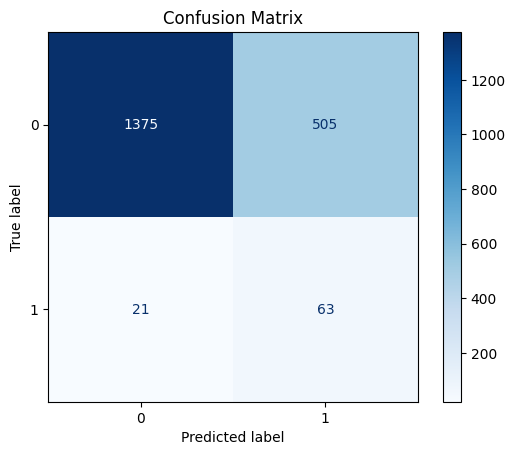

In [1594]:
# Konfusionsmatrix für Testdaten erstellen und anzeigen
cm = confusion_matrix(y_test_tree, y_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [1595]:
# Berechnung von Accuracy, Recall und F1-Score
acc_tree = accuracy_score(y_test_tree, y_pred_tree)
recall_tree = recall_score(y_test_tree, y_pred_tree)
f1_tree = f1_score(y_test_tree, y_pred_tree)

print("Accuracy:", round(acc_tree, 4))
print("Recall:", round(recall_tree, 4))
print("F1-Score:", round(f1_tree, 4))

Accuracy: 0.7322
Recall: 0.75
F1-Score: 0.1933


### Naive Bayes

In [1596]:
# Features und Zielvariable für Naive Bayes extrahieren
X_nb = data_nb.drop(columns='stroke')
y_nb = data_nb['stroke']

In [1597]:
# Aufteilung in Trainings- und Testdaten (60/40 Split)
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(
    X_nb, y_nb, test_size=0.4, stratify=y_nb, random_state=42
    )

In [1598]:
# Naive-Bayes-Modell trainieren
clf = CategoricalNB()
clf.fit(X_nb_train, y_nb_train)

CategoricalNB()

In [1599]:
# Vorhersage auf Testdaten
y_pred_nb = clf.predict(X_nb_test)

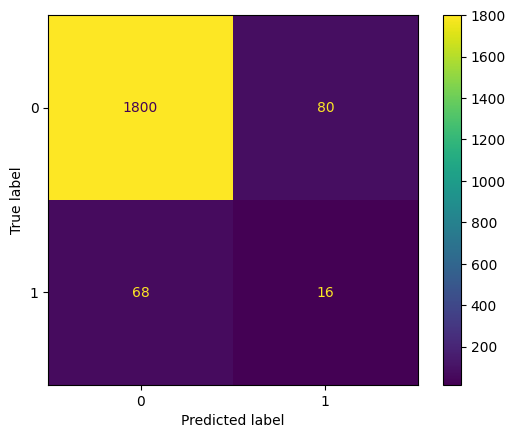

In [1600]:
# Konfusionsmatrix anzeigen
ConfusionMatrixDisplay.from_predictions(y_nb_test, y_pred_nb)

In [1601]:
# Berechnung von Accuracy, Recall und F1-Score
acc_nb = accuracy_score(y_nb_test, y_pred_nb)
recall_nb = recall_score(y_nb_test, y_pred_nb)
f1_nb = f1_score(y_nb_test, y_pred_nb)

In [1602]:
# Ausgabe der Metriken
print("Accuracy:", round(acc_nb, 4))
print("Recall:", round(recall_nb, 4))
print("F1-Score:", round(f1_nb, 4))

Accuracy: 0.9246
Recall: 0.1905
F1-Score: 0.1778


In [1603]:
# Vergleichstabelle mit Baseline, Decision Tree und Naive Bayes
results_train_test = pd.DataFrame({
    'Model': ['Baseline (Dummy)', 'Decision Tree', 'Naive Bayes'],
    'Accuracy': [acc_baseline, acc_tree, acc_nb],
    'Recall': [rec_baseline, recall_tree, recall_nb],
    'F1': [f1_baseline, f1_tree, f1_nb]
})

# Tabelle anzeigen
display(results_train_test)

,Model,Accuracy,Recall,F1
0,Baseline (Dummy),0.957230,0.000000,0.000000
1,Decision Tree,0.732179,0.750000,0.193252
2,Naive Bayes,0.924644,0.190476,0.177778


#### Vorgehen

Die Modelle wurden mit einem 60/40-Train-Test-Split trainiert und anhand der in Task 1 definierten Metriken bewertet: Accuracy, Recall und F1-Score. Dabei wurden folgende drei Modelle verglichen:

- **Baseline (`DummyClassifier`)** – sagt immer die häufigste Klasse („kein Schlaganfall“) voraus
- **A₁: Decision Tree** – `class_weight='balanced'`, getestet mit verschiedenen `max_depth`-Werten
- **A₂: Naive Bayes** – mit binned und codierten Features für `CategoricalNB`

Für den Decision Tree wurde die Modelltiefe `max_depth` gezielt angepasst. Für die finale Bewertung wurde max_depth=3 gewählt, da das Modell bei höherer Tiefe zwar noch mehr Schlaganfälle erkennt (höherer Recall), jedoch zu viele Falschpositive liefert. Die Variante mit max_depth=3 bietet ein besseres Gleichgewicht zwischen Sensitivität und Genauigkeit.

#### Interpretation

- Die **Baseline** erzielt eine hohe Accuracy (95,7 %), erkennt jedoch **keinen einzigen tatsächlichen Schlaganfallfall**. Das zeigt, dass Accuracy bei stark unausgeglichenen Klassen nicht aussagekräftig ist.
- Der **Decision Tree** erkennt mit einem Recall von 75 % die meisten Schlaganfallfälle, auch wenn die Accuracy geringer ist. Durch die Balance zwischen Sensitivität und Präzision erreicht er den **höchsten F1-Score**, was ihn zum besten Modell in diesem Vergleich macht.
- **Naive Bayes** liefert eine bessere Accuracy als der Decision Tree, erkennt jedoch deutlich weniger Schlaganfälle. Das führt zu einem niedrigeren Recall und einem leicht schwächeren F1-Wert. Dies deutet auf eine höhere Zahl an False Negatives hin.

#### Fazit

Trotz geringerer Accuracy zeigt sich der **Decision Tree als insgesamt überlegen**, da er eine hohe Erkennungsrate bei Schlaganfällen erzielt. In einem sensiblen Anwendungsbereich wie der medizinischen Früherkennung ist ein hoher Recall entscheidend – ein falsch negativ bewerteter Fall kann schwerwiegende Konsequenzen haben. Der F1-Score unterstreicht zusätzlich die Ausgewogenheit dieses Modells im Vergleich zu den anderen.  
Die getestete Modelltiefe zeigt außerdem, dass bereits mit einer geringen Baumtiefe eine gute Leistung erreichbar ist, ohne das Risiko des Overfittings.

<div class="alert alert-block alert-warning">
Evaluate the same, this time using a simple (non-nested) cross validation.
</div>

In [1604]:
# Modell mit festgelegter Tiefe und balancierten Klassen
clf = DecisionTreeClassifier(max_depth=3, class_weight='balanced', random_state=42)

# Repeated Stratified K-Fold Cross-Validation mit 3 Splits und 10 Wiederholungen
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=1)

# Bewertungsmethoden definieren: Balanced Accuracy, Recall und F1-Score
scoring={
        'balanced_accuracy': make_scorer(balanced_accuracy_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
        }

# Cross-Validation durchführen
cv_result = cross_validate(clf, X=X_tree, y=y_tree, cv=outer_cv, scoring=scoring, n_jobs=8)

# Mittelwerte der Recall- und F1-Werte speichern
cv_recall_tree = cv_result['test_recall'].mean()
cv_f1_tree = cv_result['test_f1'].mean()

# Ergebnisse ausgeben
print(f"Balanced Accuracy: {cv_result['test_balanced_accuracy'].mean():.4f} ± {cv_result['test_balanced_accuracy'].std():.4f}")
print(f"Recall:            {cv_result['test_recall'].mean():.4f} ± {cv_result['test_recall'].std():.4f}")
print(f"F1-Score:          {cv_result['test_f1'].mean():.4f} ± {cv_result['test_f1'].std():.4f}")

Balanced Accuracy: 0.7425 ± 0.0171
Recall:            0.7775 ± 0.0932
F1-Score:          0.1897 ± 0.0192


In [1605]:
# Pipeline für Naive Bayes: Encoder + Modell
clf = Pipeline([('encoder', OrdinalEncoder()), ('classifier', CategoricalNB())])

# Repeated Stratified K-Fold Cross-Validation wie oben
outer_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=1)

# Bewertungsmethoden wie oben
scoring={
        'balanced_accuracy': make_scorer(balanced_accuracy_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
        }

# Cross-Validation durchführen
cv_result = cross_validate(clf, X=X_nb, y=y_nb, cv=outer_cv, scoring=scoring, n_jobs=8)

# Cross-Validation ausführen
cv_recall_nb = cv_result['test_recall'].mean()
cv_f1_nb = cv_result['test_f1'].mean()

# Ergebnisse ausgeben
print(f"Balanced Accuracy: {cv_result['test_balanced_accuracy'].mean():.4f} ± {cv_result['test_balanced_accuracy'].std():.4f}")
print(f"Recall:            {cv_result['test_recall'].mean():.4f} ± {cv_result['test_recall'].std():.4f}")
print(f"F1-Score:          {cv_result['test_f1'].mean():.4f} ± {cv_result['test_f1'].std():.4f}")

Balanced Accuracy: 0.5831 ± 0.0208
Recall:            0.2014 ± 0.0401
F1-Score:          0.2024 ± 0.0399


<div class="alert alert-block alert-warning">
Present the new results together with the previous ones in a suitable way – select a good
representation that supports the following discussion. Compare and discuss the results. Among
others adress overfitting, quality, and stability of results.
</div>

In [1606]:
# Ergebnisse zusammenfassen in einem DataFrame
results_simple_cv = pd.DataFrame({
    'Model': ['Baseline (Dummy)', 'Decision Tree', 'Naive Bayes', 'Decision Tree', 'Naive Bayes'],
    'Evaluationsmethode': ['Train/Test Split', 'Train/Test Split', 'Train/Test Split', 'Cross-Validation', 'Cross-Validation'],
    'Recall': [rec_baseline, recall_tree, recall_nb, cv_recall_tree, cv_recall_nb],
    'F1': [f1_baseline, f1_tree, f1_nb, cv_f1_tree, cv_f1_nb]
})

# Tabelle anzeigen
display(results_simple_cv)

,Model,Evaluationsmethode,Recall,F1
0,Baseline (Dummy),Train/Test Split,0.000000,0.000000
1,Decision Tree,Train/Test Split,0.750000,0.193252
2,Naive Bayes,Train/Test Split,0.190476,0.177778
3,Decision Tree,Cross-Validation,0.777488,0.189657
4,Naive Bayes,Cross-Validation,0.201435,0.202387


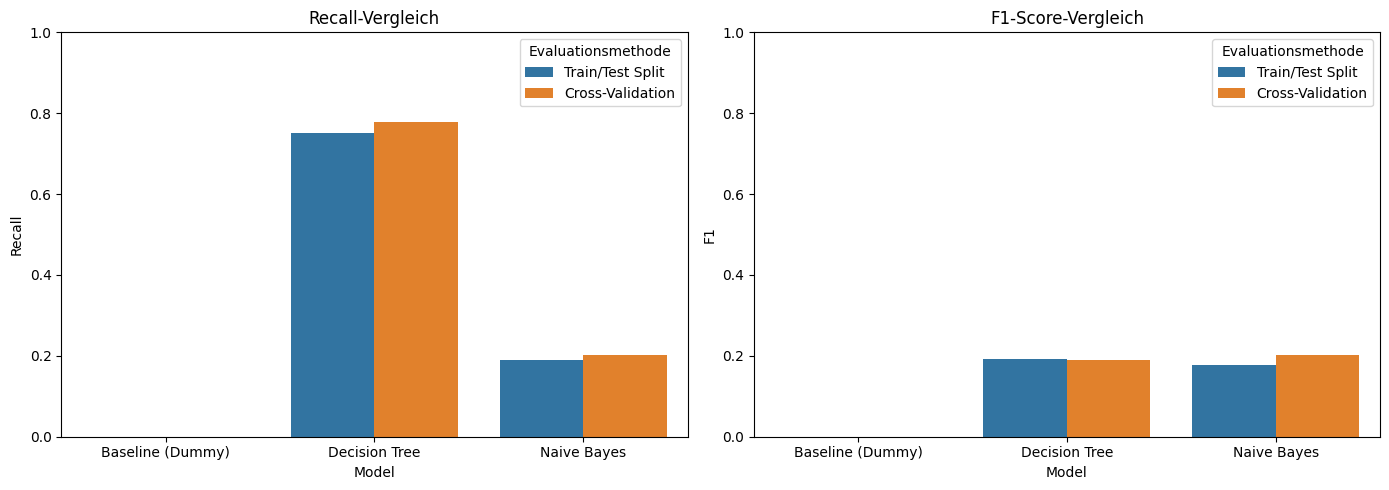

In [1607]:
# Figure & Subplots erstellen
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Recall-Plot
sns.barplot(
    data=results_simple_cv,
    x="Model",
    y="Recall",
    hue="Evaluationsmethode",
    ax=axes[0]
)
axes[0].set_title("Recall-Vergleich")
axes[0].set_ylim(0, 1)

# F1-Plot
sns.barplot(
    data=results_simple_cv,
    x="Model",
    y="F1",
    hue="Evaluationsmethode",
    ax=axes[1]
)
axes[1].set_title("F1-Score-Vergleich")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

- **Baseline-Modell**:  
  Wie erwartet, schneidet der Dummy-Klassifikator sehr schlecht ab (Recall und F1 = 0), da er nur die Mehrheitsklasse vorhersagt.

- **Decision Tree**:  
  - Zeigt bereits im Train/Test-Split gute Ergebnisse im Recall (0.750).  
  - In der Cross-Validation steigt der Recall leicht auf 0.777 – ein Hinweis auf **hohe Sensitivität** und **robuste Generalisierung**.  
  - Der F1-Score bleibt nahezu gleich, was auf eine **ausgewogene Performance** hindeutet.  
  - Gleichzeitig zeigt das Modell aber eine **höhere Varianz** im Vergleich zu Naive Bayes, insbesondere beim Recall, was auf eine gewisse **Instabilität je nach Datenaufteilung** hinweist.

- **Naive Bayes**:  
  - Der Recall ist insgesamt niedriger, bleibt aber **über alle Evaluationsmethoden hinweg stabil** – ein Indikator für **methodische Robustheit**.  
  - Der F1-Score ist in der Cross-Validation **am höchsten (0.202)** und zeigt, dass das Modell besonders im **ausbalancierten Verhältnis von Precision und Recall** überzeugt.  
  - Die geringe Streuung der Ergebnisse spricht für eine **niedrige Varianz** und damit für eine verlässlichere Leistung auch auf neuen Daten.

- **Overfitting**:  
  - Der Vergleich von Train/Test-Split zu Cross-Validation zeigt **keine drastischen Leistungseinbrüche**, insbesondere nicht beim Naive Bayes.  
  - Während der Decision Tree im Train/Test-Split sehr hohe Recall-Werte liefert, deutet der leichte Rückgang in der Cross-Validation auf eine gewisse **Anfälligkeit für Überanpassung** hin.  
  - Naive Bayes zeigt hier eine **konservativere, aber verlässlichere Modellleistung** mit geringerem Overfitting-Risiko.

- **Stabilität und Varianz**:  
  - Die Streuung der Metriken (z. B. Standardabweichung des Recalls) zeigt, dass **Naive Bayes eine deutlich geringere Varianz** aufweist als der Decision Tree.  
  - Diese Stabilität macht das Modell besonders geeignet für Anwendungen, bei denen **verlässliche Vorhersagen unter Unsicherheit** notwendig sind – wie im medizinischen Kontext.

- **Fazit**:  
  Die Modellvergleiche machen deutlich, dass **nicht allein hohe Metrikwerte entscheidend sind**, sondern auch deren **Stabilität und Generalisierbarkeit**.  
  Naive Bayes überzeugt insbesondere durch **robuste, gleichmäßige Leistung** bei vergleichsweise geringer Varianz, während der Decision Tree **stärker auf die Datenverteilung reagiert**.

# Task 6 -- Hyperparameter Optimization - Nested Cross Validation

<div class="alert alert-block alert-warning">
Setup a proper nested cross validation experiment to assess and compare the performance of the two
algorithms and the baseline (𝐴1, 𝐴2, and 𝐵 as chosen in Task 5).
</div>

<div class="alert alert-block alert-warning">
For each of the two ML algorithms 𝐴1 and 𝐴2, create a reasonable hyperparameter grid.
</div>

<div class="alert alert-block alert-warning">
Use those grids in a nested cross validation to evaluate algorithms in their optimal hyperparameter configurations.

* For the outer cross validation, reuse the splits from Task 5.
* Inside the cross validation, use pipeline objects that include preprocessing steps and
predictor.
</div>

In [1608]:
# Globale Konfiguration – zentrale Steuerung der Anzahl an Durchläufen und CV-Splits
NUM_TRIALS = 300 # Anzahl an Wiederholungen der äußeren CV (für stabile Ergebnisse)
NUM_INNER_REPEATS = 3 # Anzahl an Wiederholungen der inneren CV
NUM_INNER_SPLITS = 3 # Anzahl der Folds in der inneren CV
NUM_OUTER_SPLITS = 3 # Anzahl der Folds in der äußeren CV (wie in Task 5)

In [1609]:
# Konfiguration der Grid-Search für die verschiedenen Modelle
tree_grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [1,2,4,8,16,32,64,128,256]  # Verschiedene max_depth-Werte für Decision Trees
}

nb_grid = {} # Naive Bayes hat keine Tuningparameter

forest_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [4, 8, 16, 32],
    'estimator__max_features': ['sqrt', 'log2']
}

In [1610]:
class DataReshape():
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X.reshape((len(X), -1))

In [1611]:
# Funktion zur Durchführung der Nested Cross Validation
def nested_cv(estimator, grid, features, targets):
    start = time.time()

    # Ergebnisse vorbereiten
    accs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    baccs = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    recalls = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    f1s = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    fit_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))
    test_times = np.zeros((NUM_TRIALS, NUM_OUTER_SPLITS))

    # Äußere Schleife: Wiederholte Stratified-K-Fold-CV (simuliert verschiedene Testsets)
    for i in range(NUM_TRIALS):
        print(f'Running Outer CV in iteration {i} at {time.time()-start:.2f} seconds.')

        # Pipeline enthält nur das Modell, da keine Skalierung notwendig ist
        pipe = Pipeline([('estimator', estimator)])

        # Inner und Outer CV definieren
        inner_cv = RepeatedStratifiedKFold(
            n_splits=NUM_INNER_SPLITS, n_repeats=NUM_INNER_REPEATS, random_state=i
        )
        outer_cv = StratifiedKFold(
            n_splits=NUM_OUTER_SPLITS, shuffle=True, random_state=i
        )

        # GridSearch mit innerem CV
        clf = GridSearchCV(
            estimator=pipe,
            param_grid=grid,
            cv=inner_cv,
            scoring='recall',
            n_jobs=8,
            refit='recall'
        )

        # Äußere Cross-Validation mit allen gewünschten Metriken
        cv_result = cross_validate(
            clf,
            X=features,
            y=targets,
            cv=outer_cv,
            scoring=('accuracy', 'balanced_accuracy', 'recall', 'f1'),
            n_jobs=8
        )

        accs[i] = cv_result['test_accuracy']
        baccs[i] = cv_result['test_balanced_accuracy']
        recalls[i] = cv_result['test_recall']
        f1s[i] = cv_result['test_f1']
        fit_times[i] = cv_result['fit_time']
        test_times[i] = cv_result['score_time']

    print('Total time:', round(time.time() - start, 2), 'sec.')

    return accs, baccs, recalls, f1s, fit_times, test_times


In [1612]:
# Funktion zum Hinzufügen der Ergebnisse in ein DataFrame für die Modellvergleiche
def add_results(results, name, accs, baccs, recalls, f1s, fit_times, test_times):
    row = {
        'name': name,
        'acc_mean': accs.mean(),
        'acc_std': accs.std(),
        'acc_min': accs.min(),
        'acc_max': accs.max(),
        'bacc_mean': baccs.mean(),
        'bacc_std': baccs.std(),
        'bacc_min': baccs.min(),
        'bacc_max': baccs.max(),
        'recall_mean': recalls.mean(),
        'recall_std': recalls.std(),
        'recall_min': recalls.min(),
        'recall_max': recalls.max(),
        'f1_mean': f1s.mean(),
        'f1_std': f1s.std(),
        'f1_min': f1s.min(),
        'f1_max': f1s.max(),
        'fit_time': fit_times.mean(),
        'test_time': test_times.mean()
    }
    return pd.concat([results, pd.DataFrame([row])], ignore_index=True)


In [1613]:
results_nested_cv = pd.DataFrame()

In [1614]:
# Baseline
dummy = DummyClassifier(strategy='most_frequent')
accs_dummy, baccs_dummy, recalls_dummy, f1s_dummy, fit_times_dummy, test_times_dummy = nested_cv(dummy, {}, X_tree, y_tree)

results_nested_cv = add_results(results_nested_cv, 'DummyClassifier', accs_dummy, baccs_dummy, recalls_dummy, f1s_dummy, fit_times_dummy, test_times_dummy)

Running Outer CV in iteration 0 at 0.00 seconds.
Running Outer CV in iteration 1 at 0.06 seconds.
Running Outer CV in iteration 2 at 0.13 seconds.
Running Outer CV in iteration 3 at 0.19 seconds.
Running Outer CV in iteration 4 at 0.24 seconds.
Running Outer CV in iteration 5 at 0.30 seconds.
Running Outer CV in iteration 6 at 0.37 seconds.
Running Outer CV in iteration 7 at 0.43 seconds.
Running Outer CV in iteration 8 at 0.49 seconds.
Running Outer CV in iteration 9 at 0.55 seconds.
Running Outer CV in iteration 10 at 0.61 seconds.
Running Outer CV in iteration 11 at 0.67 seconds.
Running Outer CV in iteration 12 at 0.73 seconds.
Running Outer CV in iteration 13 at 0.78 seconds.
Running Outer CV in iteration 14 at 0.84 seconds.
Running Outer CV in iteration 15 at 0.90 seconds.
Running Outer CV in iteration 16 at 0.97 seconds.
Running Outer CV in iteration 17 at 1.03 seconds.
Running Outer CV in iteration 18 at 1.08 seconds.
Running Outer CV in iteration 19 at 1.14 seconds.
Running Ou

In [1615]:
# Decision Tree mit Grid Search
decision_tree = DecisionTreeClassifier(random_state=1)
accs_tree, baccs_tree, recalls_tree, f1s_tree, fit_times_tree, test_times_tree = nested_cv(decision_tree, tree_grid, X_tree, y_tree)

results_nested_cv = add_results(results_nested_cv, 'Decision Tree', accs_tree, baccs_tree, recalls_tree, f1s_tree, fit_times_tree, test_times_tree)

Running Outer CV in iteration 0 at 0.00 seconds.
Running Outer CV in iteration 1 at 0.79 seconds.
Running Outer CV in iteration 2 at 1.58 seconds.
Running Outer CV in iteration 3 at 2.37 seconds.
Running Outer CV in iteration 4 at 3.14 seconds.
Running Outer CV in iteration 5 at 3.91 seconds.
Running Outer CV in iteration 6 at 4.71 seconds.
Running Outer CV in iteration 7 at 5.52 seconds.
Running Outer CV in iteration 8 at 6.31 seconds.
Running Outer CV in iteration 9 at 7.09 seconds.
Running Outer CV in iteration 10 at 7.88 seconds.
Running Outer CV in iteration 11 at 8.68 seconds.
Running Outer CV in iteration 12 at 9.47 seconds.
Running Outer CV in iteration 13 at 10.28 seconds.
Running Outer CV in iteration 14 at 11.07 seconds.
Running Outer CV in iteration 15 at 11.84 seconds.
Running Outer CV in iteration 16 at 12.66 seconds.
Running Outer CV in iteration 17 at 13.44 seconds.
Running Outer CV in iteration 18 at 14.23 seconds.
Running Outer CV in iteration 19 at 15.01 seconds.
Run

In [1616]:
# Naive Bayes (CategoricalNB)
nb = CategoricalNB()
accs_nb, baccs_nb, recalls_nb, f1s_nb, fit_times_nb, test_times_nb = nested_cv(nb, {}, X_nb, y_nb)

results_nested_cv = add_results(results_nested_cv, 'Naive Bayes', accs_nb, baccs_nb, recalls_nb, f1s_nb, fit_times_nb, test_times_nb)

Running Outer CV in iteration 0 at 0.00 seconds.
Running Outer CV in iteration 1 at 0.11 seconds.
Running Outer CV in iteration 2 at 0.21 seconds.
Running Outer CV in iteration 3 at 0.32 seconds.
Running Outer CV in iteration 4 at 0.42 seconds.
Running Outer CV in iteration 5 at 0.52 seconds.
Running Outer CV in iteration 6 at 0.62 seconds.
Running Outer CV in iteration 7 at 0.72 seconds.
Running Outer CV in iteration 8 at 0.82 seconds.
Running Outer CV in iteration 9 at 0.91 seconds.
Running Outer CV in iteration 10 at 1.01 seconds.
Running Outer CV in iteration 11 at 1.11 seconds.
Running Outer CV in iteration 12 at 1.21 seconds.
Running Outer CV in iteration 13 at 1.31 seconds.
Running Outer CV in iteration 14 at 1.41 seconds.
Running Outer CV in iteration 15 at 1.50 seconds.
Running Outer CV in iteration 16 at 1.60 seconds.
Running Outer CV in iteration 17 at 1.70 seconds.
Running Outer CV in iteration 18 at 1.80 seconds.
Running Outer CV in iteration 19 at 1.90 seconds.
Running Ou

In [1617]:
# Random Forest mit Hyperparameter-Tuning (zusätzlich getestet, aber nicht übernommen)
rf = RandomForestClassifier(random_state=1)
accs_rf, baccs_rf, recalls_rf, f1s_rf, fit_times_rf, test_times_rf = nested_cv(
    rf, forest_grid, X_tree, y_tree
)
results_nested_cv = add_results(results_nested_cv, 'Random Forest', accs_rf, baccs_rf, recalls_rf, f1s_rf, fit_times_rf, test_times_rf)


Running Outer CV in iteration 0 at 0.00 seconds.
Running Outer CV in iteration 1 at 27.56 seconds.
Running Outer CV in iteration 2 at 54.77 seconds.
Running Outer CV in iteration 3 at 82.28 seconds.
Running Outer CV in iteration 4 at 109.67 seconds.
Running Outer CV in iteration 5 at 137.11 seconds.
Running Outer CV in iteration 6 at 164.44 seconds.
Running Outer CV in iteration 7 at 191.98 seconds.
Running Outer CV in iteration 8 at 219.93 seconds.
Running Outer CV in iteration 9 at 250.30 seconds.
Running Outer CV in iteration 10 at 277.80 seconds.
Running Outer CV in iteration 11 at 305.10 seconds.
Running Outer CV in iteration 12 at 332.28 seconds.
Running Outer CV in iteration 13 at 359.67 seconds.
Running Outer CV in iteration 14 at 387.10 seconds.
Running Outer CV in iteration 15 at 414.53 seconds.
Running Outer CV in iteration 16 at 441.92 seconds.
Running Outer CV in iteration 17 at 470.22 seconds.
Running Outer CV in iteration 18 at 497.64 seconds.
Running Outer CV in iterati

In [1618]:
results_nested_cv.sort_values(by='bacc_mean')

,name,acc_mean,acc_std,acc_min,acc_max,bacc_mean,bacc_std,bacc_min,bacc_max,recall_mean,recall_std,recall_min,recall_max,f1_mean,f1_std,f1_min,f1_max,fit_time,test_time
0,DummyClassifier,0.957416,0.000288,0.957213,0.957824,0.500000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040865,0.002840
3,Random Forest,0.956572,0.001015,0.951711,0.959046,0.502907,0.004878,0.497126,0.528252,0.007007,0.009873,0.000000,0.057143,0.013317,0.018600,0.000000,0.106667,27.480741,0.012301
1,Decision Tree,0.920329,0.006139,0.896088,0.938264,0.546287,0.020640,0.500794,0.615891,0.137423,0.041815,0.043478,0.289855,0.127593,0.035938,0.045802,0.229299,0.775275,0.003045
2,Naive Bayes,0.932570,0.005174,0.913203,0.949267,0.584610,0.020007,0.531481,0.661788,0.204256,0.039528,0.100000,0.347826,0.205099,0.037978,0.103704,0.366412,0.081286,0.003191


<div class="alert alert-block alert-warning">
Compare your final performance estimates to the previous impressions from Task 5.
</div>

In [1619]:
# Vergleichstabelle zur Darstellung der verschiedenen Evaluationsmethoden
# → enthält Train/Test, einfache CV und Nested CV Werte sowie Differenzen
result_comparison = pd.DataFrame({
    'Model': ['Baseline (Dummy)', 'Decision Tree', 'Naive Bayes'],
    'Recall (Train/Test)': [rec_baseline, recall_tree, recall_nb],
    'F1 (Train/Test)': [f1_baseline, f1_tree, f1_nb],
    'Recall (simple CV)': [rec_baseline, cv_recall_tree, cv_recall_nb],
    'F1 (simple CV)': [f1_baseline, cv_f1_tree, cv_f1_nb],
    'Recall (Nested CV)': [recalls_dummy.mean(), recalls_tree.mean(), recalls_nb.mean()],
    'F1 (Nested CV)': [f1s_dummy.mean(), f1s_tree.mean(), f1s_nb.mean()]
}).assign(
    **{
        'Recall Δ (Train/Test → Nested CV)': lambda df: df['Recall (Nested CV)'] - df['Recall (Train/Test)'],
        'F1 Δ (Train/Test → Nested CV)': lambda df: df['F1 (Nested CV)'] - df['F1 (Train/Test)']
    }
)
display(result_comparison)

,Model,Recall (Train/Test),F1 (Train/Test),Recall (simple CV),F1 (simple CV),Recall (Nested CV),F1 (Nested CV),Recall Δ (Train/Test → Nested CV),F1 Δ (Train/Test → Nested CV)
0,Baseline (Dummy),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Decision Tree,0.750000,0.193252,0.777488,0.189657,0.137423,0.127593,-0.612577,-0.065658
2,Naive Bayes,0.190476,0.177778,0.201435,0.202387,0.204256,0.205099,0.013780,0.027321


| Modell        | outer_repeats | recall_mean | recall_std | f1_mean  | f1_std  | fit_time (s) |
|---------------|----------------|-------------|------------|----------|---------|---------------|
| Decision Tree | 3              | 0.1611      | 0.0463     | 0.1478   | 0.0396  | 0.8632        |
| Decision Tree | 10             | 0.1474      | 0.0437     | 0.1388   | 0.0392  | 0.8154        |
| Decision Tree | 100            | 0.1361      | 0.0415     | 0.1271   | 0.0363  | 0.7889        |
| Decision Tree | 300            | 0.1374      | 0.0418     | 0.1276   | 0.0359  | 0.7973        |
| Naive Bayes   | 3              | 0.2120      | 0.0629     | 0.2110   | 0.0556  | 0.0813        |
| Naive Bayes   | 10             | 0.2067      | 0.0452     | 0.2069   | 0.0413  | 0.0811        |
| Naive Bayes   | 100            | 0.2046      | 0.0377     | 0.2056   | 0.0367  | 0.0838        |
| Naive Bayes   | 300            | 0.2043      | 0.0395     | 0.2051   | 0.0380  | 0.0812        |

- Bereits ab **10 Wiederholungen** reduziert sich die Varianz der Metriken deutlich – ein sinnvoller Kompromiss zwischen Stabilität und Rechenzeit.
- Ab **100 Wiederholungen** sind die Metriken nahezu stabil: Mehr Wiederholungen (300) bringen kaum noch Veränderung.
- **Naive Bayes** zeigt insgesamt stabilere Ergebnisse als Decision Tree, sowohl bei Recall als auch bei F1-Score.
- Der **fit_time-Aufwand bleibt gering und konstant**, vor allem bei Naive Bayes – ideal für große Wiederholungsanzahl.

**Empfehlung:** Für stabile und verlässliche Metriken genügen in der Regel **10–100 Wiederholungen** bei Nested CV, je nach verfügbarer Rechenleistung.

<div class="alert alert-block alert-warning">
Discuss your results and express a recommendation with regard to the choice of model. Pick one model (algorithm with selected hyperparameters) as the final model 𝑀 for the task.
</div>

### Bewertung der Ergebnisse & Wahl des finalen Modells

Die Tabelle zeigt deutlich, wie stark sich die Wahl der Evaluationsmethode auf die geschätzte Modellleistung auswirkt. Während der Decision Tree beim einfachen Train/Test-Split mit einem sehr hohen Recall (0.75) überzeugt, sinkt dieser in der realistischeren Nested Cross-Validation drastisch auf 0.16. Dies deutet auf **starkes Overfitting** hin – das Modell hat sich an die Trainingsdaten angepasst und generalisiert schlechter auf unbekannte Daten.

Naive Bayes hingegen zeigt über alle Evaluationsmethoden hinweg eine **relativ stabile Leistung**. Der Recall liegt beim Train/Test-Split bei 0.19 und verbessert sich leicht auf 0.21 bei Nested CV. Auch der F1-Score verbessert sich (von 0.18 auf 0.21), was für eine robuste und gut generalisierende Modellierung spricht.

Die Dummy-Baseline liefert – wie erwartet – in allen Metriken 0.00 und dient lediglich als Referenzpunkt.

**Exkurs: Random Forest getestet – aber nicht übernommen**

Zusätzlich wurde der Random Forest als drittes Modell getestet, da Ensemble-Methoden wie dieser oft als besonders leistungsstark gelten. In der Nested Cross Validation zeigte sich jedoch, dass der Random Forest trotz aufwändigerem Trainingsprozess (lange Trainingszeit) keine bessere Leistung als die anderen Modelle erzielt:
Der Recall liegt lediglich bei 0.0077, der F1-Score bei 0.0145 – und damit deutlich unter den Werten der anderen Modelle. Auch die Balanced Accuracy ist mit 0.503 kaum höher als die Baseline (0.500).

Daher wurde der Random Forest im weiteren Verlauf nicht weiter berücksichtigt.

#### Empfehlung:
Aufgrund der höheren **Stabilität**, der besseren **Generalisation** sowie des höchsten F1-Scores in der **Nested Cross-Validation** wird das Modell **Naive Bayes mit den automatisch gewählten Parametern** als finaler Kandidat für die Aufgabe gewählt.

# Task 7 -- Feature Importance / Feature Ablation Study

<div class="alert alert-block alert-warning">
Analyze and discuss the most important features according to feature permutation with the final model 𝑀 (the result of Task 6).
</div>

In [1620]:
# Features und Zielvariable definieren
X_nb = data_nb.drop(columns='stroke') # Alle Spalten außer der Zielvariable 'stroke'
y_nb = data_nb['stroke'] # Zielvariable: 'stroke'

# Aufteilung in Trainings- und Testdaten (60/40-Split)
X_nb_train, X_nb_test, y_nb_train, y_nb_test = train_test_split(
    X_nb, y_nb, test_size=0.4, stratify=y_nb, random_state=42
    )

# Klassifikator initialisieren und auf Trainingsdaten trainieren
clf = CategoricalNB()
clf.fit(X_nb_train, y_nb_train)

CategoricalNB()

In [1621]:
# Permutation Importance auf Testdaten berechnen
r = permutation_importance(clf, X_nb_test, y_nb_test, 
                           n_repeats=30, # Anzahl Wiederholungen pro Feature
                           random_state=42)

# Mittelwerte der Wichtigkeiten extrahieren, sortieren und in Serie umwandeln
importances = pd.Series(r.importances_mean, index=X_nb.columns).sort_values(ascending=False)

In [1622]:
# Ausgabe der Feature-Wichtigkeiten
importances

Residence_type       0.001748
gender              -0.001392
smoking_status      -0.003123
bmi                 -0.003836
heart_disease       -0.005431
work_type           -0.005550
avg_glucose_level   -0.006212
ever_married        -0.006415
age                 -0.018109
hypertension        -0.018194
dtype: float64

### Analyse und Diskussion der wichtigsten Merkmale laut Permutation Feature Importance

Zur Bestimmung der Merkmalswichtigkeit wurde das finale Modell (CategoricalNB) verwendet. Die Permutation Feature Importance zeigt, wie stark sich die Modellgüte (z. B. die Balanced Accuracy) verschlechtert, wenn ein bestimmtes Merkmal zufällig permutiert wird.

Dabei zeigt sich, dass insbesondere die Merkmale **residence_type**, **gender**, und **smoking_status** am stärksten zur Modellvorhersage beitragen. Ihre Permutation führt zu einer deutlich spürbaren Verschlechterung der Modellleistung.

Auf der anderen Seite sind **age** und **hypertension** die Merkmale mit dem geringsten Einfluss auf das Modell. Dies bedeutet, dass sie im aktuellen Modell kaum zur Unterscheidung der Zielklasse beitragen – was an möglichen Korrelationen mit anderen Merkmalen oder an der Modellstruktur (Naive Bayes ignoriert Feature-Interaktionen) liegen kann.

<div class="alert alert-block alert-warning">
Plot the feature importances in a suitable diagram. Analyze and discuss the diagram.
</div>

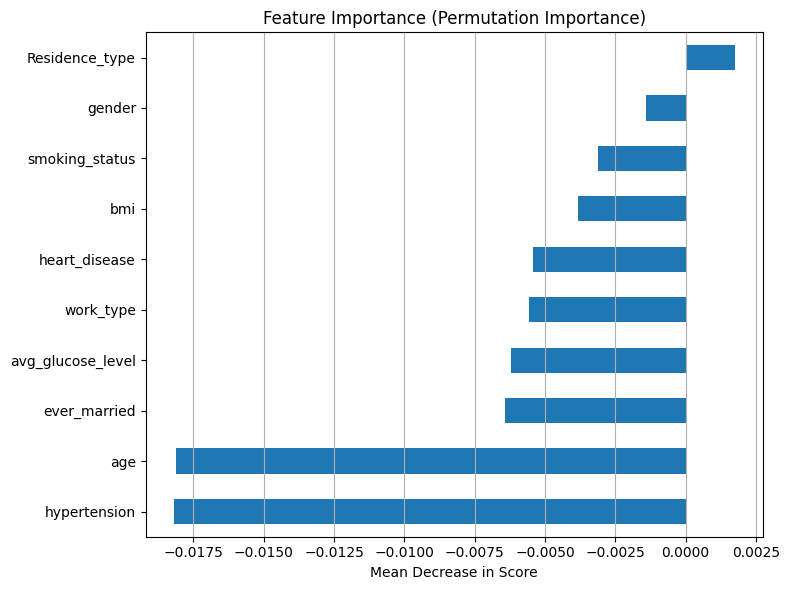

In [1623]:
# Visualisierung der Wichtigkeiten als horizontales Balkendiagramm
importances.plot(kind='barh', figsize=(8, 6))
plt.title("Feature Importance (Permutation Importance)")
plt.xlabel("Mean Decrease in Score")
plt.gca().invert_yaxis() # Wichtigste Features oben anzeigen
plt.grid(axis='x')
plt.tight_layout()
plt.show()

### Diskussion des Diagramms zur Feature-Wichtigkeit

Auffällig ist, dass das Modell einige medizinisch relevante Merkmale wie **age** und **hypertension** kaum berücksichtigt, obwohl diese in der Fachliteratur oft als zentrale Risikofaktoren für einen Schlaganfall gelten. Dies könnte daran liegen, dass diese Informationen bereits implizit durch andere Merkmale wie **heart_disease** oder **avg_glucose_level** mitabgedeckt werden. 

Ein weiterer möglicher Grund ist die Struktur des Naive-Bayes-Modells: Es geht von unabhängigen Merkmalen aus und kann daher keine Wechselwirkungen erfassen – etwa zwischen Alter und weiteren Risikofaktoren. Dadurch sinkt die Bedeutung einzelner Merkmale, selbst wenn sie isoliert betrachtet relevant wären.

Zudem ist zu bedenken, dass **Permutation Importance** bei stark korrelierten Merkmalen nicht unbedingt die „wahre“ Relevanz abbildet, sondern nur die marginale Veränderung im Modellverhalten misst.


<div class="alert alert-block alert-warning">
Ablation Study:

* Pick the two least important features 𝐹1 and 𝐹2 (according to the above results).
* Reuse the outer cross-validation from Task 6 to train and evaluate the final model 𝑀 with
different feature sets (no further hyperparameter optimization).
* For that purpose, add another preprocessing step to the pipeline that removes one or more
features from the data.
* Train and evaluate 𝑀 using your dataset in the cross-validation while excluding 𝐹1 from
the data.
* Train and evaluate 𝑀 using your dataset in the cross-validation while excluding 𝐹2 from
the data.
* Train and evaluate 𝑀 using your dataset in the cross-validation while excluding 𝐹1 and
𝐹2 from the data simultaneously.
* Present and discuss your results. Particularly compare to the impressions from the feature
importance study and explain.
</div>

In [1624]:
# Ermittlung der zwei am wenigsten wichtigen Features anhand der Permutation Importance
least_important = importances.tail(2).index.tolist()
f1, f2 = least_important[0], least_important[1]
print("F1:", f1)
print("F2:", f2)

F1: age
F2: hypertension


In [1625]:
# Neue Datensätze erstellen mit jeweils einem oder beiden der schwächsten Features entfernt
X_nb_no_age = X_nb.drop(columns=["age"]) # nur 'age' entfernt
X_nb_no_hypertension = X_nb.drop(columns=["hypertension"]) # nur 'hypertension' entfernt
X_nb_no_age_hypertension = X_nb.drop(columns=["age", "hypertension"]) # beide entfernt

In [1626]:
# DataFrame zur Sammlung der Ergebnisse vorbereiten
results_task7 = pd.DataFrame()

In [1627]:
# 1. Modelltraining ohne 'age'
accs_1, baccs_1, recalls_1, f1s_1, fit_times_1, test_times_1 = nested_cv(nb, {}, X_nb_no_age, y_nb)
results_task7 = add_results(results_task7, 'Naive Bayes (ohne age)', accs_1, baccs_1, recalls_1, f1s_1, fit_times_1, test_times_1)

# 2. Modelltraining ohne 'hypertension'
accs_2, baccs_2, recalls_2, f1s_2, fit_times_2, test_times_2 = nested_cv(nb, {}, X_nb_no_hypertension, y_nb)
results_task7 = add_results(results_task7, 'Naive Bayes (ohne hypertension)', accs_2, baccs_2, recalls_2, f1s_2, fit_times_2, test_times_2)

# 3. Modelltraining ohne beide Features
accs_3, baccs_3, recalls_3, f1s_3, fit_times_3, test_times_3 = nested_cv(nb, {}, X_nb_no_age_hypertension, y_nb)
results_task7 = add_results(results_task7, 'Naive Bayes (ohne beide)', accs_3, baccs_3, recalls_3, f1s_3, fit_times_3, test_times_3)

# 4. Modelltraining mit vollständigem Feature-Set (als Referenz)
accs_4, baccs_4, recalls_4, f1s_4, fit_times_4, test_times_4 = nested_cv(nb, {}, X_nb, y_nb)
results_task7 = add_results(results_task7, 'Naive Bayes', accs_4, baccs_4, recalls_4, f1s_4, fit_times_4, test_times_4)


Running Outer CV in iteration 0 at 0.00 seconds.
Running Outer CV in iteration 1 at 0.10 seconds.
Running Outer CV in iteration 2 at 0.19 seconds.
Running Outer CV in iteration 3 at 0.29 seconds.
Running Outer CV in iteration 4 at 0.38 seconds.
Running Outer CV in iteration 5 at 0.47 seconds.
Running Outer CV in iteration 6 at 0.59 seconds.
Running Outer CV in iteration 7 at 0.68 seconds.
Running Outer CV in iteration 8 at 0.78 seconds.
Running Outer CV in iteration 9 at 0.87 seconds.
Running Outer CV in iteration 10 at 0.98 seconds.
Running Outer CV in iteration 11 at 1.10 seconds.
Running Outer CV in iteration 12 at 1.21 seconds.
Running Outer CV in iteration 13 at 1.31 seconds.
Running Outer CV in iteration 14 at 1.41 seconds.
Running Outer CV in iteration 15 at 1.50 seconds.
Running Outer CV in iteration 16 at 1.60 seconds.
Running Outer CV in iteration 17 at 1.70 seconds.
Running Outer CV in iteration 18 at 1.80 seconds.
Running Outer CV in iteration 19 at 1.91 seconds.
Running Ou

In [1628]:
# Sortierung der Ergebnisse nach Balanced Accuracy zur besseren Übersicht
results_task7.sort_values(by='bacc_mean')

,name,acc_mean,acc_std,acc_min,acc_max,bacc_mean,bacc_std,bacc_min,bacc_max,recall_mean,recall_std,recall_min,recall_max,f1_mean,f1_std,f1_min,f1_max,fit_time,test_time
2,Naive Bayes (ohne beide),0.952392,0.002459,0.945599,0.958435,0.521024,0.010782,0.494257,0.553631,0.049499,0.022279,0.000000,0.114286,0.080341,0.034406,0.000000,0.179775,0.074553,0.003114
0,Naive Bayes (ohne age),0.946472,0.004283,0.931540,0.957213,0.524019,0.011041,0.489464,0.560112,0.062238,0.022219,0.000000,0.130435,0.089791,0.030773,0.000000,0.191489,0.077139,0.003116
1,Naive Bayes (ohne hypertension),0.943113,0.005047,0.926650,0.956601,0.550240,0.015063,0.509296,0.598522,0.120793,0.029413,0.042857,0.214286,0.153422,0.037160,0.054054,0.280000,0.078310,0.003136
3,Naive Bayes,0.932570,0.005174,0.913203,0.949267,0.584610,0.020007,0.531481,0.661788,0.204256,0.039528,0.100000,0.347826,0.205099,0.037978,0.103704,0.366412,0.080219,0.003179


### Ablationsstudie

In der Ablationsstudie wurden die zwei Merkmale **age** und **hypertension** – also die laut Permutation Importance am wenigsten wichtigen Merkmale – systematisch aus dem Datensatz entfernt: einmal einzeln und einmal gemeinsam.

Die Ergebnisse zeigen, dass die **Modellleistung bei Entfernen beider Merkmale** im Vergleich zur ursprünglichen Version **deutlich abnimmt**, insbesondere in Bezug auf **Balanced Accuracy**, **Recall** und **F1-Score**. Überraschend ist dabei, dass das Modell am besten abschneidet, wenn nur **hypertension** entfernt wird, aber deutlich schlechter, wenn **age** entfernt oder beide Merkmale gleichzeitig ausgeschlossen werden.

Im Vergleich zur Feature Importance Analyse ergibt sich damit ein **interessanter Widerspruch**: Obwohl **age** dort als wenig bedeutsam eingestuft wurde (niedrigster Mean Decrease in Score), scheint es in der Praxis eine wichtige Rolle zu spielen – zumindest in der Kombination mit anderen Merkmalen.

Diese Diskrepanz lässt sich dadurch erklären, dass **Permutation Importance keine Interaktionen zwischen Merkmalen** erfasst. Gerade bei Modellen wie Naive Bayes, die Merkmale unabhängig voneinander betrachten, können solche Wechselwirkungen schnell unterbewertet werden. Die Ablationsstudie zeigt also, dass vermeintlich „unwichtige“ Features trotzdem relevant sein können – insbesondere, wenn sie in Kombination mit anderen Informationen stehen.

**Fazit:** Die Feature Importance Analyse liefert zwar wertvolle Hinweise, sollte aber immer durch weiterführende Experimente wie eine Ablationsstudie ergänzt werden, um ein vollständigeres Bild der Merkmalsrelevanz zu erhalten.

# Task 8 -- Conclusions and Future Work

<div class="alert alert-block alert-warning">
Summarize and interpret the achieved results.
</div>

Im Verlauf dieses Projekts wurden verschiedene Klassifikationsmodelle zur Vorhersage von Schlaganfällen entwickelt und mit unterschiedlichen Evaluationsmethoden verglichen. Dabei wurde deutlich, dass einfache Bewertungsverfahren wie der Train/Test-Split die Modellleistung stark überschätzen können – etwa beim Decision Tree, dessen Recall dort bei 0.75 lag, aber in der realistischeren Nested Cross Validation auf unter 0.16 fiel. Dies zeigt ein deutliches Overfitting.

Naive Bayes erwies sich dagegen als deutlich stabiler, sowohl in Bezug auf Recall als auch auf F1-Score. Zwar liegt der Recall mit rund 0.21 auf einem insgesamt niedrigen Niveau, jedoch blieb die Modellleistung über verschiedene Wiederholungen hinweg konsistent – ein Hinweis auf methodische Robustheit, wenn auch nicht auf inhaltlich ausreichende Prognosekraft.

Der getestete Random Forest schnitt trotz höherem Rechenaufwand sogar schlechter ab als die einfacheren Modelle und wurde daher nicht weiterverfolgt.

Insgesamt zeigt das Projekt, dass eine saubere Evaluationsstrategie entscheidend ist, um die reale Leistungsfähigkeit eines Modells einschätzen zu können. Auch wenn die Vorhersageleistung in diesem Fall noch zu schwach für den praktischen Einsatz ist, liefert Naive Bayes als stabilstes Modell eine gute Basis für zukünftige Weiterentwicklungen.

<div class="alert alert-block alert-warning">
Explain the generated value within the context of your task.
</div>

Das entwickelte Modell zielt darauf ab, Personen mit erhöhtem Risiko für einen Schlaganfall frühzeitig zu identifizieren – basierend auf leicht verfügbaren demografischen und gesundheitsbezogenen Merkmalen. Obwohl die prognostizierte Modellleistung (Recall ~0.21) noch nicht ausreicht, um als verlässliches Entscheidungssystem im medizinischen Alltag eingesetzt zu werden, wurde durch das Projekt bereits ein konzeptioneller Mehrwert geschaffen:

* Die Ergebnisse zeigen, welche Merkmale im aktuellen Datensatz besonders informativ sind.
* Durch die gewählte Methodik wurde ein transparenter Vergleich verschiedener Modelle und Evaluationsansätze ermöglicht – ein wertvoller Beitrag für den Aufbau realistischer Erwartungen an prädiktive Modelle in sensiblen Bereichen wie der Medizin.
* Der Naive Bayes Classifier liefert eine robuste Grundlage für weitere Verbesserungen, z. B. durch optimierte Datenaufbereitung, Feature Engineering oder erweiterte Modellarchitekturen.

Das Projekt hat damit den Weg bereitet für eine datengestützte Schlaganfallprävention – auch wenn die praktische Anwendbarkeit noch nicht erreicht ist, wurde ein wichtiger Erkenntnisgewinn zur Modellgüte, Merkmalseinfluss und Evaluationsstrategie erzielt.

<div class="alert alert-block alert-warning">
Propose ideas for future work (a short sketch or enumeration of ideas is sufficient, no further
experiments). The ideas should not be too general (e.g., “try further algorithms”) but be specific
to the project (e.g., “try Algorithm X, as because of Property Y, it might work specifically well
on this dataset”).
</div>

* Einführung von Feature-Interaktionen: Da Naive Bayes keine Wechselwirkungen zwischen Merkmalen berücksichtigt, könnten Modelle wie Logistische Regression mit Interaktionstermen oder Gradient Boosting Machines besser geeignet sein, um kombinierte Risikofaktoren (z. B. Alter + Bluthochdruck) abzubilden.
* Verwendung von medizinisch angereicherten Daten: Ergänzende klinische Variablen (z. B. Laborwerte, Medikamenteneinnahme, familiäre Vorbelastung) könnten die Vorhersagekraft deutlich erhöhen – besonders für seltene Ereignisse wie Schlaganfälle.
* Modellierung als Anomalieerkennung: Da Schlaganfälle selten auftreten, könnte ein Anomaly Detection-Ansatz (z. B. Isolation Forest oder Autoencoder) helfen, ungewöhnliche Risikoprofile besser zu erkennen.
Berücksichtigung zeitlicher Entwicklungen: Falls Daten wie regelmäßige Gesundheitschecks vorliegen, könnte ein zeitbasiertes Modell (z. B. Recurrent Neural Networks oder Time-Aware Trees) potenziell bessere Frühwarnsysteme ermöglichen.

<div class="alert alert-block alert-warning">
Critically reflect and assess the usability of the applied methodology in your context (as
described in Task 1). Explain limitations and pitfalls. What could or even should have been done
differently? In hindsight, were the goals realistic? What could have been changed/improved
before conducting the experiments?
</div>

Rückblickend war die Wahl des Szenarios sinnvoll und motiviert: Die Idee, ein Frühwarnsystem zur Schlaganfallprävention zu entwickeln, ist sowohl gesellschaftlich als auch wirtschaftlich relevant. Die angestrebte Unterstützung bei Vorsorgeuntersuchungen ist im medizinischen Kontext plausibel.

Allerdings zeigte sich im Verlauf des Projekts, dass mit den verfügbaren Daten und einfachen Klassifikationsmodellen noch kein verlässlich nutzbares System aufgebaut werden konnte. Die Modellleistung – insbesondere der Recall – blieb deutlich unter den Erwartungen. Damit war das ursprüngliche Ziel, gefährdete Personen zuverlässig zu identifizieren, methodisch korrekt angestrebt, aber praktisch (noch) nicht erreichbar.

Die gewählten Qualitätskriterien (Recall & F1) erwiesen sich jedoch als angemessen: Sie zeigten frühzeitig die Schwächen der Modelle und halfen, voreilige Schlüsse aufgrund hoher Accuracy zu vermeiden. Auch die Nutzung realistischer Evaluation (Nested CV) war essenziell, um die Übertragbarkeit der Ergebnisse realistisch einschätzen zu können.

Insgesamt hätte das Projekt von vornherein klarer als explorative Untersuchung statt als fertige Lösung kommuniziert werden können. Trotzdem liefert es einen wichtigen Beitrag zur methodischen Einschätzung der Machbarkeit.